# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [1]:
# 필요한 라이브러리를 설치합니다.
# !pip install timm
# !pip install matplotlib
# !pip install seaborn
# !pip install optuna

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [2]:
import os
import time
import random
import copy

import optuna, math
import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler  # Mixed Precision용

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import wandb
from datetime import datetime

# 한글 폰트 설정 (시각화용)
plt.rcParams['font.family'] = ['DejaVu Sans']

In [3]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [4]:
# #  WandB Login and Configuration
# """
# 팀원 사용 가이드:

# 1. WandB 계정 생성: https://wandb.ai/signup
# 2. 이 셀 실행 시 로그인 프롬프트가 나타나면 개인 API 키 입력
# 3. EXPERIMENT_NAME을 다음과 같이 변경:
#    - "member1-baseline"
#    - "member2-augmentation-test"  
#    - "member3-hyperparameter-tuning"
#    등등 각자 다른 이름 사용

# 4. 팀 대시보드 URL: [여기에 당신의 프로젝트 URL 추가]

# 주의사항:
# - 절대 API 키를 코드에 하드코딩하지 마세요
# - EXPERIMENT_NAME만 변경하고 PROJECT_NAME은 그대로 두세요
# - 각자 개인 계정으로 로그인해서 실험을 추가하세요
# """

# # WandB 로그인 (각자 실행)
# try:
#     if wandb.api.api_key is None:
#         print("WandB에 로그인이 필요합니다.")
#         wandb.login()
#     else:
#         print(f"WandB 로그인 상태: {wandb.api.viewer()['username']}")
# except:
#     print("WandB 로그인을 진행합니다...")
#     wandb.login()

# # 프로젝트 설정 (각자 수정할 부분)
# PROJECT_NAME = "document-classification-team"  # 모든 팀원 동일
# ENTITY = None  # 각자 개인 계정 사용
# EXPERIMENT_NAME = "efficientnet-b3-baseline"  # 팀원별로 변경 (예: "member1-hyperopt", "member2-augmentation")

# print(f"프로젝트: {PROJECT_NAME}")
# print(f"실험명: {EXPERIMENT_NAME}")
# print("팀원들은 EXPERIMENT_NAME을 각자 다르게 변경해주세요!")

In [5]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# 데이터셋 클래스를 정의합니다. (Hard Augmentation 포함)
class ImageDataset(Dataset):
    def __init__(self, data, path, epoch=0, total_epochs=10, is_train=True):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.epoch = epoch
        self.total_epochs = total_epochs
        self.is_train = is_train
        
        # Hard augmentation 확률 계산
        self.p_hard = 0.2 + 0.3 * (epoch / total_epochs) if is_train else 0
        
        # Normal augmentation
        self.normal_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
            ], p=0.6),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
            A.GaussNoise(var_limit=(30.0, 100.0), p=0.7),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
        
        # Hard augmentation
        self.hard_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
                A.Rotate(limit=[-15,15], p=1.0),
            ], p=0.8),
            A.OneOf([
                A.MotionBlur(blur_limit=15, p=1.0),
                A.GaussianBlur(blur_limit=15, p=1.0),
            ], p=0.95),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.9),
            A.GaussNoise(var_limit=(50.0, 150.0), p=0.8),
            A.JpegCompression(quality_lower=70, quality_upper=100, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        
        # 배치별 증강 선택
        if self.is_train and random.random() < self.p_hard:
            img = self.hard_aug(image=img)['image']
        else:
            img = self.normal_aug(image=img)['image']
        
        return img, target

In [6]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    scaler = GradScaler()  # Mixed Precision용
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)
        
        # Cutmix/Mixup 적용 (30% 확률)
        if random.random() < 0.3:
            mixed_x, y_a, y_b, lam = mixup_data(image, targets, alpha=1.0)
            with autocast(): preds = model(mixed_x)
            loss = lam * loss_fn(preds, y_a) + (1 - lam) * loss_fn(preds, y_b)
        else:
            with autocast(): preds = model(image)
            loss = loss_fn(preds, targets)

        model.zero_grad(set_to_none=True)

        scaler.scale(loss).backward()  # Mixed Precision용
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()  # Mixed Precision용

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [7]:
# validation을 위한 함수 추가
def validate_one_epoch(loader, model, loss_fn, device):
    """
    한 에폭 검증을 수행하는 함수
    - model.eval()로 모델을 평가 모드로 전환
    - torch.no_grad()로 gradient 계산 비활성화하여 메모리 절약
    - 검증 데이터에 대한 loss, accuracy, f1 score 계산
    """
    model.eval()  # 모델을 평가 모드로 전환 (dropout, batchnorm 비활성화)
    val_loss = 0
    preds_list = []
    targets_list = []
    
    with torch.no_grad():  # gradient 계산 비활성화로 메모리 절약
        pbar = tqdm(loader, desc="Validating")
        for image, targets in pbar:
            image = image.to(device)
            targets = targets.to(device)
            
            preds = model(image)  # 모델 예측
            loss = loss_fn(preds, targets)  # 손실 계산
            
            val_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())  # 예측 클래스 저장
            targets_list.extend(targets.detach().cpu().numpy())  # 실제 클래스 저장
            
            pbar.set_description(f"Val Loss: {loss.item():.4f}")
    
    val_loss /= len(loader)  # 평균 손실 계산
    val_acc = accuracy_score(targets_list, preds_list)  # 정확도 계산
    val_f1 = f1_score(targets_list, preds_list, average='macro')  # Macro F1 계산 (대회 평가지표)
    
    ret = {
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1,
    }
    
    return ret

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [8]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '../data/'

# model config
# model_name = 'tf_efficientnetv2_b3' # 'resnet50' 'efficientnet-b0', ...
# model_name = 'swin_base_patch4_window12_384_in22k'
model_name = 'convnext_base_384_in22ft1k'

# training config
img_size = 384
LR = 2e-4
EPOCHS = 50
BATCH_SIZE = 24
num_workers = 8
EMA = True  # Exponential Moving Average 사용 여부

In [9]:
# Optuna를 사용한 하이퍼파라미터 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    def objective(trial):
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
        
        # 간단한 3-fold CV로 빠른 평가
        skf_simple = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        fold_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf_simple.split(train_df, train_df['target'])):
            # 모델 생성
            model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
            optimizer = Adam(model.parameters(), lr=lr)
            loss_fn = nn.CrossEntropyLoss()
            
            # 간단한 2 epoch 학습
            for epoch in range(2):
                train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
            
            val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
            fold_scores.append(val_ret['val_f1'])
        
        return np.mean(fold_scores)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    
    # 최적 파라미터 적용
    LR = study.best_params['lr']
    BATCH_SIZE = study.best_params['batch_size']
    print(f"Best params: {study.best_params}")

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [10]:
# # augmentation을 위한 transform 코드
# trn_transform = A.Compose([
#     # 비율 보존 리사이징 (핵심 개선)
#     A.LongestMaxSize(max_size=img_size),
#     A.PadIfNeeded(min_height=img_size, min_width=img_size, 
#                   border_mode=0, value=0),
    
#     # 문서 특화 회전 (정확한 90도 배수)
#     A.OneOf([
#         A.Rotate(limit=[90,90], p=1.0),
#         A.Rotate(limit=[180,180], p=1.0),
#         A.Rotate(limit=[270,270], p=1.0),
#     ], p=0.6),
    
#     # 테스트 특화 강화 증강
#     A.OneOf([
#         A.MotionBlur(blur_limit=7, p=1.0),
#         A.GaussianBlur(blur_limit=7, p=1.0),
#     ], p=0.9),
    
#     A.RandomBrightnessContrast(
#         brightness_limit=0.3, 
#         contrast_limit=0.3, 
#         p=0.8
#     ),
#     A.GaussNoise(var_limit=(30.0, 100.0), p=0.7),
#     A.HorizontalFlip(p=0.5),
    
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2(),
# ])

# # test image 변환을 위한 transform 코드
# tst_transform = A.Compose([
#     A.LongestMaxSize(max_size=img_size),
#     A.PadIfNeeded(min_height=img_size, min_width=img_size, 
#                   border_mode=0, value=0),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2(),
# ])

In [11]:
# Optuna 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    # 위의 objective 함수와 study 코드
    pass

# K-Fold 적용

In [12]:
# K-Fold 설정
N_FOLDS = 5  # 5-fold로 설정 (데이터가 적으므로)
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# 클래스별 최소 샘플 보장 확인
# for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
#     assert len(np.unique(train_df.iloc[val_idx]['target'])) == 17

# 전체 학습 데이터 로드
train_df = pd.read_csv("../data/train.csv")

# K-Fold 결과를 저장할 리스트
fold_results = []
fold_models = []  # 각 fold의 최고 성능 모델을 저장
fold_class_accuracies = [] # 각 fold의 클래스별 정확도 저장

print(f"Starting {N_FOLDS}-Fold Cross Validation...")

# LR = best_params['lr']
# BATCH_SIZE = best_params['batch_size']

# K-Fold Cross Validation 시작
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    print(f"\n{'='*50}")
    print(f"FOLD {fold + 1}/{N_FOLDS}")
    print(f"{'='*50}")
    
    current_model = model_name
    
    # 현재 fold의 train/validation 데이터 분할
    train_fold_df = train_df.iloc[train_idx].reset_index(drop=True)
    val_fold_df = train_df.iloc[val_idx].reset_index(drop=True)
    
    # 현재 fold의 Dataset 생성
    trn_dataset = ImageDataset(
        train_fold_df,
        "../data/train/",
        # transform=trn_transform
        epoch=0,  # 현재 epoch 전달
        total_epochs=EPOCHS,
        is_train=True
    )
    
    val_dataset = ImageDataset(
        val_fold_df,
        "../data/train/",
        # transform=tst_transform  # 검증에는 증강 적용 안함
        epoch=0,  # validation은 epoch 관계없음
        total_epochs=EPOCHS,
        is_train=False  # validation이므로 hard augmentation 비활성화
    )
    
    # 현재 fold의 DataLoader 생성
    trn_loader = DataLoader(
        trn_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    print(f"Train samples: {len(trn_dataset)}, Validation samples: {len(val_dataset)}")
    
    # 모델 초기화 (각 fold마다 새로운 모델)
    model = timm.create_model(
        current_model,
        pretrained=True,
        num_classes=17
    ).to(device)
    
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)  # Label Smoothing 적용
    optimizer = Adam(model.parameters(), lr=LR)
    
    # Learning Rate Scheduler 추가
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
    
    # 현재 fold의 최고 성능 추적
    best_val_f1 = 0.0
    best_model = None
    
    # 현재 fold 학습
    for epoch in range(EPOCHS):
        # Training
        train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
        
        # Validation
        val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
        
        # Scheduler step 추가
        scheduler.step()
        
        print(f"Epoch {epoch+1:2d} | "
              f"Train Loss: {train_ret['train_loss']:.4f} | "
              f"Train F1: {train_ret['train_f1']:.4f} | "
              f"Val Loss: {val_ret['val_loss']:.4f} | "
              f"Val F1: {val_ret['val_f1']:.4f}")
        
        # 최고 성능 모델 저장
        if val_ret['val_f1'] > best_val_f1:
            best_val_f1 = val_ret['val_f1']
            best_model = copy.deepcopy(model.state_dict())
            
            # Best 모델 분석
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for image, targets in val_loader:
                    preds = model(image.to(device)).argmax(dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_targets.extend(targets.numpy())
            
            # 클래스별 정확도
            fold_class_acc = {}
            for c in range(17):
                mask = np.array(val_targets) == c
                if mask.sum() > 0:
                    fold_class_acc[c] = (np.array(val_preds)[mask] == c).mean()
    
    # 현재 fold 결과 저장
    fold_results.append({
        'fold': fold + 1,
        'best_val_f1': best_val_f1,
        'train_samples': len(trn_dataset),
        'val_samples': len(val_dataset)
    })
    
    fold_models.append(best_model)
    
    print(f"Fold {fold + 1} Best Validation F1: {best_val_f1:.4f}")
    
    fold_class_accuracies.append(fold_class_acc) # 각 fold의 클래스별 정확도 저장

# K-Fold 결과 요약
print(f"\n{'='*60}")
print("K-FOLD CROSS VALIDATION RESULTS")
print(f"{'='*60}")

val_f1_scores = [result['best_val_f1'] for result in fold_results]
mean_f1 = np.mean(val_f1_scores)
std_f1 = np.std(val_f1_scores)

for result in fold_results:
    print(f"Fold {result['fold']}: {result['best_val_f1']:.4f}")

print(f"\nMean CV F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Best single fold: {max(val_f1_scores):.4f}")

Starting 5-Fold Cross Validation...

FOLD 1/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.1467: 100%|██████████| 14/14 [00:04<00:00,  3.43it/s]

Epoch  1 | Train Loss: 2.0279 | Train F1: 0.3637 | Val Loss: 1.0530 | Val F1: 0.7214



Val Loss: 1.2344: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]

Epoch  2 | Train Loss: 1.1149 | Train F1: 0.6772 | Val Loss: 0.7486 | Val F1: 0.8053



Val Loss: 1.2180: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]

Epoch  3 | Train Loss: 0.9278 | Train F1: 0.7103 | Val Loss: 0.6717 | Val F1: 0.8648



Val Loss: 1.6113: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]

Epoch  4 | Train Loss: 0.9049 | Train F1: 0.7174 | Val Loss: 0.6991 | Val F1: 0.8747



Val Loss: 0.8601: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]

Epoch  5 | Train Loss: 0.8590 | Train F1: 0.7630 | Val Loss: 0.6090 | Val F1: 0.8914



Val Loss: 0.9017: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]

Epoch  6 | Train Loss: 0.7858 | Train F1: 0.7548 | Val Loss: 0.5729 | Val F1: 0.9037



Val Loss: 1.0037: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]

Epoch  7 | Train Loss: 0.7080 | Train F1: 0.7498 | Val Loss: 0.5510 | Val F1: 0.9165



Val Loss: 1.2832: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch  8 | Train Loss: 0.7452 | Train F1: 0.8336 | Val Loss: 0.6177 | Val F1: 0.8990


Val Loss: 1.5216: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]


Epoch  9 | Train Loss: 0.8166 | Train F1: 0.8053 | Val Loss: 0.6178 | Val F1: 0.8990


Val Loss: 0.9302: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch 10 | Train Loss: 0.7578 | Train F1: 0.7581 | Val Loss: 0.5551 | Val F1: 0.9087


Val Loss: 0.7542: 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]

Epoch 11 | Train Loss: 0.6796 | Train F1: 0.8258 | Val Loss: 0.5437 | Val F1: 0.9334



Val Loss: 0.6120: 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]

Epoch 12 | Train Loss: 0.7766 | Train F1: 0.6998 | Val Loss: 0.5089 | Val F1: 0.9390



Val Loss: 1.0371: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]


Epoch 13 | Train Loss: 0.7291 | Train F1: 0.7673 | Val Loss: 0.5799 | Val F1: 0.9145


Val Loss: 0.9915: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]


Epoch 14 | Train Loss: 0.6247 | Train F1: 0.8344 | Val Loss: 0.5296 | Val F1: 0.9340


Val Loss: 1.3626: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]


Epoch 15 | Train Loss: 0.6007 | Train F1: 0.8829 | Val Loss: 0.5336 | Val F1: 0.9385


Val Loss: 0.7107: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]


Epoch 16 | Train Loss: 0.5215 | Train F1: 0.8854 | Val Loss: 0.5196 | Val F1: 0.9376


Val Loss: 0.9384: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]

Epoch 17 | Train Loss: 0.6369 | Train F1: 0.8232 | Val Loss: 0.5073 | Val F1: 0.9477



Val Loss: 0.4916: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 18 | Train Loss: 0.5459 | Train F1: 0.8856 | Val Loss: 0.4767 | Val F1: 0.9309


Val Loss: 0.4957: 100%|██████████| 14/14 [00:03<00:00,  4.45it/s]


Epoch 19 | Train Loss: 0.5896 | Train F1: 0.8738 | Val Loss: 0.5041 | Val F1: 0.9246


Val Loss: 0.3506: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]

Epoch 20 | Train Loss: 0.6448 | Train F1: 0.7945 | Val Loss: 0.4382 | Val F1: 0.9538



Val Loss: 0.3498: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]


Epoch 21 | Train Loss: 0.5698 | Train F1: 0.8543 | Val Loss: 0.5067 | Val F1: 0.9192


Val Loss: 1.4452: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]


Epoch 22 | Train Loss: 0.6427 | Train F1: 0.7889 | Val Loss: 0.5636 | Val F1: 0.9351


Val Loss: 0.6293: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch 23 | Train Loss: 0.6066 | Train F1: 0.8093 | Val Loss: 0.4873 | Val F1: 0.9456


Val Loss: 0.3391: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]


Epoch 24 | Train Loss: 0.5380 | Train F1: 0.8813 | Val Loss: 0.4402 | Val F1: 0.9465


Val Loss: 0.3296: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]

Epoch 25 | Train Loss: 0.5388 | Train F1: 0.8721 | Val Loss: 0.4583 | Val F1: 0.9613



Val Loss: 1.8354: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]


Epoch 26 | Train Loss: 0.5766 | Train F1: 0.8543 | Val Loss: 0.6270 | Val F1: 0.9152


Val Loss: 0.3621: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]


Epoch 27 | Train Loss: 0.6207 | Train F1: 0.7504 | Val Loss: 0.4622 | Val F1: 0.9567


Val Loss: 0.3472: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 28 | Train Loss: 0.5323 | Train F1: 0.9158 | Val Loss: 0.4582 | Val F1: 0.9484


Val Loss: 0.3539: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]

Epoch 29 | Train Loss: 0.5027 | Train F1: 0.8322 | Val Loss: 0.4318 | Val F1: 0.9690



Val Loss: 0.3575: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch 30 | Train Loss: 0.5284 | Train F1: 0.9005 | Val Loss: 0.4656 | Val F1: 0.9438


Val Loss: 0.4693: 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]


Epoch 31 | Train Loss: 0.5084 | Train F1: 0.8896 | Val Loss: 0.4383 | Val F1: 0.9628


Val Loss: 0.4740: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]


Epoch 32 | Train Loss: 0.5097 | Train F1: 0.8719 | Val Loss: 0.4269 | Val F1: 0.9650


Val Loss: 0.3520: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]


Epoch 33 | Train Loss: 0.5162 | Train F1: 0.8947 | Val Loss: 0.4330 | Val F1: 0.9618


Val Loss: 0.4795: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]


Epoch 34 | Train Loss: 0.5678 | Train F1: 0.8210 | Val Loss: 0.4547 | Val F1: 0.9610


Val Loss: 0.3352: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]


Epoch 35 | Train Loss: 0.5374 | Train F1: 0.8561 | Val Loss: 0.4375 | Val F1: 0.9614


Val Loss: 0.3297: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]


Epoch 36 | Train Loss: 0.5671 | Train F1: 0.8123 | Val Loss: 0.4496 | Val F1: 0.9594


Val Loss: 0.3415: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]


Epoch 37 | Train Loss: 0.5161 | Train F1: 0.8848 | Val Loss: 0.4840 | Val F1: 0.9562


Val Loss: 0.3435: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]


Epoch 38 | Train Loss: 0.5418 | Train F1: 0.8571 | Val Loss: 0.4170 | Val F1: 0.9646


Val Loss: 0.3337: 100%|██████████| 14/14 [00:03<00:00,  4.43it/s]


Epoch 39 | Train Loss: 0.5276 | Train F1: 0.9125 | Val Loss: 0.4554 | Val F1: 0.9533


Val Loss: 0.4155: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]


Epoch 40 | Train Loss: 0.4933 | Train F1: 0.9300 | Val Loss: 0.4255 | Val F1: 0.9627


Val Loss: 0.5143: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]


Epoch 41 | Train Loss: 0.5731 | Train F1: 0.8349 | Val Loss: 0.4445 | Val F1: 0.9487


Val Loss: 1.1480: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]


Epoch 42 | Train Loss: 0.5396 | Train F1: 0.8393 | Val Loss: 0.4907 | Val F1: 0.9553


Val Loss: 0.4622: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 43 | Train Loss: 0.5327 | Train F1: 0.8422 | Val Loss: 0.4445 | Val F1: 0.9538


Val Loss: 0.5619: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]


Epoch 44 | Train Loss: 0.4415 | Train F1: 0.9024 | Val Loss: 0.4619 | Val F1: 0.9564


Val Loss: 0.5718: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]

Epoch 45 | Train Loss: 0.5313 | Train F1: 0.8714 | Val Loss: 0.4582 | Val F1: 0.9708



Val Loss: 0.3286: 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]


Epoch 46 | Train Loss: 0.5245 | Train F1: 0.8602 | Val Loss: 0.4155 | Val F1: 0.9691


Val Loss: 0.5531: 100%|██████████| 14/14 [00:02<00:00,  4.75it/s]

Epoch 47 | Train Loss: 0.5956 | Train F1: 0.8601 | Val Loss: 0.4287 | Val F1: 0.9709



Val Loss: 0.3433: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 48 | Train Loss: 0.4881 | Train F1: 0.9138 | Val Loss: 0.4245 | Val F1: 0.9614


Val Loss: 0.3785: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]


Epoch 49 | Train Loss: 0.5829 | Train F1: 0.7884 | Val Loss: 0.4530 | Val F1: 0.9512


Val Loss: 0.4878: 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]


Epoch 50 | Train Loss: 0.5181 | Train F1: 0.8653 | Val Loss: 0.4475 | Val F1: 0.9568
Fold 1 Best Validation F1: 0.9709

FOLD 2/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.2594: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]

Epoch  1 | Train Loss: 1.9678 | Train F1: 0.3893 | Val Loss: 1.0924 | Val F1: 0.6346



Val Loss: 1.0747: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]

Epoch  2 | Train Loss: 1.2244 | Train F1: 0.6331 | Val Loss: 0.7889 | Val F1: 0.7891



Val Loss: 1.0864: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]

Epoch  3 | Train Loss: 1.0553 | Train F1: 0.7333 | Val Loss: 0.7059 | Val F1: 0.8153



Val Loss: 0.7257: 100%|██████████| 14/14 [00:03<00:00,  4.40it/s]

Epoch  4 | Train Loss: 1.0404 | Train F1: 0.6874 | Val Loss: 0.6583 | Val F1: 0.8673



Val Loss: 0.8446: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]

Epoch  5 | Train Loss: 0.8037 | Train F1: 0.7572 | Val Loss: 0.5687 | Val F1: 0.9027



Val Loss: 0.8409: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]


Epoch  6 | Train Loss: 0.7777 | Train F1: 0.7715 | Val Loss: 0.5658 | Val F1: 0.8829


Val Loss: 0.7689: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]

Epoch  7 | Train Loss: 0.8964 | Train F1: 0.7166 | Val Loss: 0.5802 | Val F1: 0.9057



Val Loss: 0.7903: 100%|██████████| 14/14 [00:03<00:00,  4.34it/s]

Epoch  8 | Train Loss: 0.8850 | Train F1: 0.7502 | Val Loss: 0.5423 | Val F1: 0.9111



Val Loss: 0.9185: 100%|██████████| 14/14 [00:03<00:00,  4.33it/s]

Epoch  9 | Train Loss: 0.6349 | Train F1: 0.8755 | Val Loss: 0.5437 | Val F1: 0.9159



Val Loss: 0.7670: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]

Epoch 10 | Train Loss: 0.7788 | Train F1: 0.7829 | Val Loss: 0.4887 | Val F1: 0.9380



Val Loss: 0.7699: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]

Epoch 11 | Train Loss: 0.7125 | Train F1: 0.8392 | Val Loss: 0.5093 | Val F1: 0.9407



Val Loss: 0.5277: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]


Epoch 12 | Train Loss: 0.6856 | Train F1: 0.8368 | Val Loss: 0.4842 | Val F1: 0.9286


Val Loss: 0.3405: 100%|██████████| 14/14 [00:03<00:00,  4.67it/s]


Epoch 13 | Train Loss: 0.6840 | Train F1: 0.7893 | Val Loss: 0.4948 | Val F1: 0.9135


Val Loss: 0.6687: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]

Epoch 14 | Train Loss: 0.6907 | Train F1: 0.8196 | Val Loss: 0.4754 | Val F1: 0.9472



Val Loss: 1.0213: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


Epoch 15 | Train Loss: 0.7927 | Train F1: 0.8035 | Val Loss: 0.5319 | Val F1: 0.9372


Val Loss: 0.4941: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 16 | Train Loss: 0.6078 | Train F1: 0.8941 | Val Loss: 0.4858 | Val F1: 0.9293


Val Loss: 0.3636: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch 17 | Train Loss: 0.6605 | Train F1: 0.7835 | Val Loss: 0.4896 | Val F1: 0.9280


Val Loss: 0.6187: 100%|██████████| 14/14 [00:03<00:00,  4.50it/s]

Epoch 18 | Train Loss: 0.5713 | Train F1: 0.8597 | Val Loss: 0.4923 | Val F1: 0.9565



Val Loss: 0.4387: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 19 | Train Loss: 0.6197 | Train F1: 0.8674 | Val Loss: 0.4831 | Val F1: 0.9338


Val Loss: 0.4109: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 20 | Train Loss: 0.6464 | Train F1: 0.8099 | Val Loss: 0.4842 | Val F1: 0.9425


Val Loss: 0.3506: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]

Epoch 21 | Train Loss: 0.5567 | Train F1: 0.8799 | Val Loss: 0.4553 | Val F1: 0.9631



Val Loss: 0.6625: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]


Epoch 22 | Train Loss: 0.5374 | Train F1: 0.8662 | Val Loss: 0.4805 | Val F1: 0.9565


Val Loss: 1.0888: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


Epoch 23 | Train Loss: 0.5808 | Train F1: 0.8472 | Val Loss: 0.5285 | Val F1: 0.9421


Val Loss: 0.4183: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 24 | Train Loss: 0.5540 | Train F1: 0.9127 | Val Loss: 0.4754 | Val F1: 0.9600


Val Loss: 0.4936: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 25 | Train Loss: 0.6663 | Train F1: 0.8220 | Val Loss: 0.4754 | Val F1: 0.9575


Val Loss: 1.0319: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]


Epoch 26 | Train Loss: 0.5602 | Train F1: 0.8955 | Val Loss: 0.5189 | Val F1: 0.9442


Val Loss: 1.0680: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]


Epoch 27 | Train Loss: 0.6193 | Train F1: 0.8089 | Val Loss: 0.5476 | Val F1: 0.9418


Val Loss: 0.3736: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


Epoch 28 | Train Loss: 0.5887 | Train F1: 0.8318 | Val Loss: 0.4817 | Val F1: 0.9433


Val Loss: 1.0907: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 29 | Train Loss: 0.5841 | Train F1: 0.8464 | Val Loss: 0.5192 | Val F1: 0.9445


Val Loss: 0.3963: 100%|██████████| 14/14 [00:03<00:00,  4.36it/s]

Epoch 30 | Train Loss: 0.6103 | Train F1: 0.7981 | Val Loss: 0.4422 | Val F1: 0.9644



Val Loss: 0.6636: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]


Epoch 31 | Train Loss: 0.5712 | Train F1: 0.8826 | Val Loss: 0.4894 | Val F1: 0.9521


Val Loss: 0.8139: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]


Epoch 32 | Train Loss: 0.5601 | Train F1: 0.9072 | Val Loss: 0.4938 | Val F1: 0.9571


Val Loss: 0.9454: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]


Epoch 33 | Train Loss: 0.6070 | Train F1: 0.8316 | Val Loss: 0.4842 | Val F1: 0.9635


Val Loss: 0.3418: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 34 | Train Loss: 0.5810 | Train F1: 0.8791 | Val Loss: 0.4578 | Val F1: 0.9581


Val Loss: 0.3525: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]


Epoch 35 | Train Loss: 0.6283 | Train F1: 0.7985 | Val Loss: 0.4731 | Val F1: 0.9487


Val Loss: 0.5050: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]

Epoch 36 | Train Loss: 0.5373 | Train F1: 0.8578 | Val Loss: 0.4644 | Val F1: 0.9695



Val Loss: 0.4332: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch 37 | Train Loss: 0.5139 | Train F1: 0.8457 | Val Loss: 0.4607 | Val F1: 0.9607


Val Loss: 0.3691: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]


Epoch 38 | Train Loss: 0.5530 | Train F1: 0.8859 | Val Loss: 0.4540 | Val F1: 0.9674


Val Loss: 0.4454: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 39 | Train Loss: 0.5834 | Train F1: 0.7986 | Val Loss: 0.4748 | Val F1: 0.9554


Val Loss: 1.0410: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


Epoch 40 | Train Loss: 0.5632 | Train F1: 0.8687 | Val Loss: 0.5221 | Val F1: 0.9613


Val Loss: 0.3922: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 41 | Train Loss: 0.5591 | Train F1: 0.8592 | Val Loss: 0.4479 | Val F1: 0.9587


Val Loss: 0.4288: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]


Epoch 42 | Train Loss: 0.4865 | Train F1: 0.9018 | Val Loss: 0.4547 | Val F1: 0.9598


Val Loss: 0.3746: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


Epoch 43 | Train Loss: 0.4847 | Train F1: 0.8804 | Val Loss: 0.4560 | Val F1: 0.9598


Val Loss: 0.4221: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]


Epoch 44 | Train Loss: 0.6288 | Train F1: 0.7999 | Val Loss: 0.4552 | Val F1: 0.9695


Val Loss: 0.6190: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch 45 | Train Loss: 0.4658 | Train F1: 0.8977 | Val Loss: 0.4657 | Val F1: 0.9693


Val Loss: 0.8310: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]


Epoch 46 | Train Loss: 0.4687 | Train F1: 0.9483 | Val Loss: 0.4703 | Val F1: 0.9695


Val Loss: 0.6368: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 47 | Train Loss: 0.5701 | Train F1: 0.8661 | Val Loss: 0.4675 | Val F1: 0.9674


Val Loss: 0.4066: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch 48 | Train Loss: 0.4597 | Train F1: 0.8792 | Val Loss: 0.4597 | Val F1: 0.9661


Val Loss: 0.4026: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]

Epoch 49 | Train Loss: 0.4929 | Train F1: 0.8685 | Val Loss: 0.4386 | Val F1: 0.9752



Val Loss: 0.8453: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]


Epoch 50 | Train Loss: 0.4896 | Train F1: 0.8866 | Val Loss: 0.4838 | Val F1: 0.9635
Fold 2 Best Validation F1: 0.9752

FOLD 3/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.4868: 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]

Epoch  1 | Train Loss: 1.9830 | Train F1: 0.3859 | Val Loss: 1.0415 | Val F1: 0.6740



Val Loss: 0.3443: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]

Epoch  2 | Train Loss: 1.2272 | Train F1: 0.6204 | Val Loss: 0.7695 | Val F1: 0.7811



Val Loss: 0.3465: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]

Epoch  3 | Train Loss: 0.9790 | Train F1: 0.6616 | Val Loss: 0.6457 | Val F1: 0.8563



Val Loss: 0.3451: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch  4 | Train Loss: 0.8338 | Train F1: 0.7863 | Val Loss: 0.6036 | Val F1: 0.8457


Val Loss: 0.3406: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]

Epoch  5 | Train Loss: 0.8463 | Train F1: 0.7508 | Val Loss: 0.5844 | Val F1: 0.8645



Val Loss: 0.3352: 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]

Epoch  6 | Train Loss: 0.7667 | Train F1: 0.7906 | Val Loss: 0.5529 | Val F1: 0.8920



Val Loss: 0.3414: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch  7 | Train Loss: 0.8598 | Train F1: 0.7577 | Val Loss: 0.5649 | Val F1: 0.8532


Val Loss: 0.3427: 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]


Epoch  8 | Train Loss: 0.7861 | Train F1: 0.8217 | Val Loss: 0.5258 | Val F1: 0.8855


Val Loss: 0.3317: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch  9 | Train Loss: 0.7401 | Train F1: 0.8135 | Val Loss: 0.5844 | Val F1: 0.8611


Val Loss: 0.3288: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]

Epoch 10 | Train Loss: 0.7701 | Train F1: 0.7726 | Val Loss: 0.4885 | Val F1: 0.9304



Val Loss: 0.3279: 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]


Epoch 11 | Train Loss: 0.7282 | Train F1: 0.8278 | Val Loss: 0.4692 | Val F1: 0.9301


Val Loss: 0.3280: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]

Epoch 12 | Train Loss: 0.6452 | Train F1: 0.8621 | Val Loss: 0.4608 | Val F1: 0.9392



Val Loss: 0.3307: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]


Epoch 13 | Train Loss: 0.6982 | Train F1: 0.8462 | Val Loss: 0.4826 | Val F1: 0.9129


Val Loss: 0.3263: 100%|██████████| 14/14 [00:03<00:00,  4.42it/s]


Epoch 14 | Train Loss: 0.6529 | Train F1: 0.8509 | Val Loss: 0.5231 | Val F1: 0.8894


Val Loss: 0.3294: 100%|██████████| 14/14 [00:03<00:00,  4.32it/s]


Epoch 15 | Train Loss: 0.7424 | Train F1: 0.8075 | Val Loss: 0.4861 | Val F1: 0.9207


Val Loss: 0.3248: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]

Epoch 16 | Train Loss: 0.7245 | Train F1: 0.7845 | Val Loss: 0.4445 | Val F1: 0.9419



Val Loss: 0.3301: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


Epoch 17 | Train Loss: 0.6622 | Train F1: 0.7788 | Val Loss: 0.4675 | Val F1: 0.9302


Val Loss: 0.3308: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 18 | Train Loss: 0.5658 | Train F1: 0.8840 | Val Loss: 0.4729 | Val F1: 0.9291


Val Loss: 0.3292: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]

Epoch 19 | Train Loss: 0.5811 | Train F1: 0.8727 | Val Loss: 0.4546 | Val F1: 0.9478



Val Loss: 0.3242: 100%|██████████| 14/14 [00:03<00:00,  4.41it/s]


Epoch 20 | Train Loss: 0.6574 | Train F1: 0.8246 | Val Loss: 0.4401 | Val F1: 0.9415


Val Loss: 0.3239: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]


Epoch 21 | Train Loss: 0.5621 | Train F1: 0.8875 | Val Loss: 0.4367 | Val F1: 0.9471


Val Loss: 0.3304: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]

Epoch 22 | Train Loss: 0.5646 | Train F1: 0.8707 | Val Loss: 0.4428 | Val F1: 0.9484



Val Loss: 0.3244: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]


Epoch 23 | Train Loss: 0.5445 | Train F1: 0.8609 | Val Loss: 0.5154 | Val F1: 0.9235


Val Loss: 0.3253: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]


Epoch 24 | Train Loss: 0.6225 | Train F1: 0.8054 | Val Loss: 0.4472 | Val F1: 0.9388


Val Loss: 0.3282: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch 25 | Train Loss: 0.5596 | Train F1: 0.8022 | Val Loss: 0.4680 | Val F1: 0.9353


Val Loss: 0.3242: 100%|██████████| 14/14 [00:03<00:00,  4.46it/s]


Epoch 26 | Train Loss: 0.5296 | Train F1: 0.8529 | Val Loss: 0.4686 | Val F1: 0.9407


Val Loss: 0.3231: 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]


Epoch 27 | Train Loss: 0.6714 | Train F1: 0.7962 | Val Loss: 0.4422 | Val F1: 0.9400


Val Loss: 0.3228: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 28 | Train Loss: 0.5652 | Train F1: 0.8407 | Val Loss: 0.4453 | Val F1: 0.9427


Val Loss: 0.3234: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 29 | Train Loss: 0.5499 | Train F1: 0.9247 | Val Loss: 0.4610 | Val F1: 0.9355


Val Loss: 0.3253: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]


Epoch 30 | Train Loss: 0.6321 | Train F1: 0.8522 | Val Loss: 0.4277 | Val F1: 0.9418


Val Loss: 0.3236: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]


Epoch 31 | Train Loss: 0.5337 | Train F1: 0.8698 | Val Loss: 0.4532 | Val F1: 0.9339


Val Loss: 0.3238: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 32 | Train Loss: 0.5561 | Train F1: 0.8569 | Val Loss: 0.4331 | Val F1: 0.9440


Val Loss: 0.3222: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]

Epoch 33 | Train Loss: 0.5230 | Train F1: 0.8869 | Val Loss: 0.4286 | Val F1: 0.9557



Val Loss: 0.3225: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch 34 | Train Loss: 0.4706 | Train F1: 0.8735 | Val Loss: 0.4417 | Val F1: 0.9508


Val Loss: 0.3230: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]

Epoch 35 | Train Loss: 0.5633 | Train F1: 0.7831 | Val Loss: 0.4044 | Val F1: 0.9641



Val Loss: 0.3225: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]

Epoch 36 | Train Loss: 0.5246 | Train F1: 0.8879 | Val Loss: 0.4019 | Val F1: 0.9671



Val Loss: 0.3222: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 37 | Train Loss: 0.5382 | Train F1: 0.8930 | Val Loss: 0.4310 | Val F1: 0.9449


Val Loss: 0.3224: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


Epoch 38 | Train Loss: 0.5564 | Train F1: 0.8138 | Val Loss: 0.4375 | Val F1: 0.9549


Val Loss: 0.3218: 100%|██████████| 14/14 [00:03<00:00,  4.44it/s]


Epoch 39 | Train Loss: 0.5351 | Train F1: 0.8730 | Val Loss: 0.4420 | Val F1: 0.9541


Val Loss: 0.3220: 100%|██████████| 14/14 [00:03<00:00,  4.35it/s]


Epoch 40 | Train Loss: 0.5528 | Train F1: 0.8646 | Val Loss: 0.4205 | Val F1: 0.9549


Val Loss: 0.3216: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 41 | Train Loss: 0.6132 | Train F1: 0.7931 | Val Loss: 0.4419 | Val F1: 0.9382


Val Loss: 0.3221: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 42 | Train Loss: 0.5191 | Train F1: 0.8739 | Val Loss: 0.4273 | Val F1: 0.9520


Val Loss: 0.3221: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]


Epoch 43 | Train Loss: 0.5204 | Train F1: 0.8519 | Val Loss: 0.4450 | Val F1: 0.9357


Val Loss: 0.3213: 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]


Epoch 44 | Train Loss: 0.5359 | Train F1: 0.8832 | Val Loss: 0.4284 | Val F1: 0.9492


Val Loss: 0.3220: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 45 | Train Loss: 0.5478 | Train F1: 0.8270 | Val Loss: 0.4512 | Val F1: 0.9448


Val Loss: 0.3219: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 46 | Train Loss: 0.5760 | Train F1: 0.8235 | Val Loss: 0.4306 | Val F1: 0.9517


Val Loss: 0.3216: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 47 | Train Loss: 0.5888 | Train F1: 0.8348 | Val Loss: 0.4339 | Val F1: 0.9470


Val Loss: 0.3224: 100%|██████████| 14/14 [00:03<00:00,  4.41it/s]


Epoch 48 | Train Loss: 0.5055 | Train F1: 0.8951 | Val Loss: 0.4420 | Val F1: 0.9401


Val Loss: 0.3218: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]


Epoch 49 | Train Loss: 0.5303 | Train F1: 0.8491 | Val Loss: 0.4501 | Val F1: 0.9479


Val Loss: 0.3215: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]


Epoch 50 | Train Loss: 0.5439 | Train F1: 0.8603 | Val Loss: 0.4368 | Val F1: 0.9487
Fold 3 Best Validation F1: 0.9671

FOLD 4/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.3813: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]

Epoch  1 | Train Loss: 2.0336 | Train F1: 0.3547 | Val Loss: 1.0616 | Val F1: 0.6835



Val Loss: 0.3390: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]

Epoch  2 | Train Loss: 1.0577 | Train F1: 0.6834 | Val Loss: 0.6769 | Val F1: 0.8412



Val Loss: 0.3389: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]

Epoch  3 | Train Loss: 0.9729 | Train F1: 0.7422 | Val Loss: 0.6137 | Val F1: 0.8785



Val Loss: 0.3347: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch  4 | Train Loss: 0.8662 | Train F1: 0.7659 | Val Loss: 0.5743 | Val F1: 0.8619


Val Loss: 0.3274: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]


Epoch  5 | Train Loss: 0.7402 | Train F1: 0.8187 | Val Loss: 0.5379 | Val F1: 0.8633


Val Loss: 0.3281: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]

Epoch  6 | Train Loss: 0.8032 | Train F1: 0.8005 | Val Loss: 0.5132 | Val F1: 0.8970



Val Loss: 0.3331: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]

Epoch  7 | Train Loss: 0.6904 | Train F1: 0.8228 | Val Loss: 0.5210 | Val F1: 0.9032



Val Loss: 0.3338: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch  8 | Train Loss: 0.8517 | Train F1: 0.7760 | Val Loss: 0.6348 | Val F1: 0.8756


Val Loss: 0.3355: 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]

Epoch  9 | Train Loss: 0.7114 | Train F1: 0.7933 | Val Loss: 0.5034 | Val F1: 0.9141



Val Loss: 0.3244: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]

Epoch 10 | Train Loss: 0.6125 | Train F1: 0.8555 | Val Loss: 0.5500 | Val F1: 0.9148



Val Loss: 0.3308: 100%|██████████| 14/14 [00:03<00:00,  4.41it/s]


Epoch 11 | Train Loss: 0.6933 | Train F1: 0.7934 | Val Loss: 0.5057 | Val F1: 0.9023


Val Loss: 0.3333: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]

Epoch 12 | Train Loss: 0.6701 | Train F1: 0.8449 | Val Loss: 0.4877 | Val F1: 0.9226



Val Loss: 0.3283: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]

Epoch 13 | Train Loss: 0.6394 | Train F1: 0.8208 | Val Loss: 0.4694 | Val F1: 0.9412



Val Loss: 0.3247: 100%|██████████| 14/14 [00:03<00:00,  4.37it/s]

Epoch 14 | Train Loss: 0.6472 | Train F1: 0.8522 | Val Loss: 0.4546 | Val F1: 0.9589



Val Loss: 0.3246: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 15 | Train Loss: 0.6581 | Train F1: 0.8185 | Val Loss: 0.4783 | Val F1: 0.9289


Val Loss: 0.3233: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 16 | Train Loss: 0.7450 | Train F1: 0.7840 | Val Loss: 0.4783 | Val F1: 0.9334


Val Loss: 0.3270: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]


Epoch 17 | Train Loss: 0.6594 | Train F1: 0.8690 | Val Loss: 0.4802 | Val F1: 0.9251


Val Loss: 0.3264: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch 18 | Train Loss: 0.5530 | Train F1: 0.8247 | Val Loss: 0.4630 | Val F1: 0.9498


Val Loss: 0.3233: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 19 | Train Loss: 0.6383 | Train F1: 0.8185 | Val Loss: 0.4684 | Val F1: 0.9438


Val Loss: 0.3238: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 20 | Train Loss: 0.6537 | Train F1: 0.8248 | Val Loss: 0.5230 | Val F1: 0.9256


Val Loss: 0.3226: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]


Epoch 21 | Train Loss: 0.6130 | Train F1: 0.8135 | Val Loss: 0.4888 | Val F1: 0.9121


Val Loss: 0.3246: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 22 | Train Loss: 0.5975 | Train F1: 0.8597 | Val Loss: 0.4476 | Val F1: 0.9517


Val Loss: 0.3285: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]

Epoch 23 | Train Loss: 0.5604 | Train F1: 0.8626 | Val Loss: 0.4466 | Val F1: 0.9596



Val Loss: 0.3218: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]


Epoch 24 | Train Loss: 0.5312 | Train F1: 0.8570 | Val Loss: 0.4835 | Val F1: 0.9468


Val Loss: 0.3217: 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]


Epoch 25 | Train Loss: 0.5638 | Train F1: 0.8931 | Val Loss: 0.4653 | Val F1: 0.9445


Val Loss: 0.3220: 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]


Epoch 26 | Train Loss: 0.5724 | Train F1: 0.8612 | Val Loss: 0.4776 | Val F1: 0.9405


Val Loss: 0.3216: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]

Epoch 27 | Train Loss: 0.5863 | Train F1: 0.8383 | Val Loss: 0.4489 | Val F1: 0.9627



Val Loss: 0.3223: 100%|██████████| 14/14 [00:03<00:00,  4.25it/s]


Epoch 28 | Train Loss: 0.5190 | Train F1: 0.8875 | Val Loss: 0.4435 | Val F1: 0.9565


Val Loss: 0.3212: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]


Epoch 29 | Train Loss: 0.5508 | Train F1: 0.8348 | Val Loss: 0.4632 | Val F1: 0.9508


Val Loss: 0.3249: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]


Epoch 30 | Train Loss: 0.6281 | Train F1: 0.7762 | Val Loss: 0.4617 | Val F1: 0.9495


Val Loss: 0.3335: 100%|██████████| 14/14 [00:03<00:00,  4.23it/s]


Epoch 31 | Train Loss: 0.6440 | Train F1: 0.7508 | Val Loss: 0.4445 | Val F1: 0.9611


Val Loss: 0.3229: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]


Epoch 32 | Train Loss: 0.5784 | Train F1: 0.9046 | Val Loss: 0.4374 | Val F1: 0.9563


Val Loss: 0.3223: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]

Epoch 33 | Train Loss: 0.4704 | Train F1: 0.8801 | Val Loss: 0.4549 | Val F1: 0.9640



Val Loss: 0.3213: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]


Epoch 34 | Train Loss: 0.5853 | Train F1: 0.7698 | Val Loss: 0.4454 | Val F1: 0.9494


Val Loss: 0.3219: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]


Epoch 35 | Train Loss: 0.5437 | Train F1: 0.8505 | Val Loss: 0.4524 | Val F1: 0.9544


Val Loss: 0.3238: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


Epoch 36 | Train Loss: 0.5242 | Train F1: 0.8447 | Val Loss: 0.4671 | Val F1: 0.9439


Val Loss: 0.3210: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 37 | Train Loss: 0.5003 | Train F1: 0.9042 | Val Loss: 0.4422 | Val F1: 0.9595


Val Loss: 0.3209: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 38 | Train Loss: 0.5664 | Train F1: 0.8183 | Val Loss: 0.4481 | Val F1: 0.9529


Val Loss: 0.3211: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]


Epoch 39 | Train Loss: 0.5776 | Train F1: 0.8392 | Val Loss: 0.4467 | Val F1: 0.9585


Val Loss: 0.3210: 100%|██████████| 14/14 [00:03<00:00,  4.41it/s]

Epoch 40 | Train Loss: 0.5756 | Train F1: 0.8244 | Val Loss: 0.4406 | Val F1: 0.9643



Val Loss: 0.3213: 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]

Epoch 41 | Train Loss: 0.5397 | Train F1: 0.8846 | Val Loss: 0.4270 | Val F1: 0.9706



Val Loss: 0.3211: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 42 | Train Loss: 0.4847 | Train F1: 0.8893 | Val Loss: 0.4444 | Val F1: 0.9603


Val Loss: 0.3212: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 43 | Train Loss: 0.5806 | Train F1: 0.8910 | Val Loss: 0.4375 | Val F1: 0.9627


Val Loss: 0.3234: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 44 | Train Loss: 0.5079 | Train F1: 0.8345 | Val Loss: 0.4510 | Val F1: 0.9690


Val Loss: 0.3213: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]


Epoch 45 | Train Loss: 0.5527 | Train F1: 0.8719 | Val Loss: 0.4343 | Val F1: 0.9588


Val Loss: 0.3297: 100%|██████████| 14/14 [00:03<00:00,  4.33it/s]


Epoch 46 | Train Loss: 0.5437 | Train F1: 0.8541 | Val Loss: 0.4267 | Val F1: 0.9619


Val Loss: 0.3211: 100%|██████████| 14/14 [00:03<00:00,  4.47it/s]


Epoch 47 | Train Loss: 0.5506 | Train F1: 0.8698 | Val Loss: 0.4320 | Val F1: 0.9622


Val Loss: 0.3216: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 48 | Train Loss: 0.5865 | Train F1: 0.8270 | Val Loss: 0.4412 | Val F1: 0.9626


Val Loss: 0.3213: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]


Epoch 49 | Train Loss: 0.5362 | Train F1: 0.8620 | Val Loss: 0.4239 | Val F1: 0.9686


Val Loss: 0.3213: 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]


Epoch 50 | Train Loss: 0.6088 | Train F1: 0.8484 | Val Loss: 0.4319 | Val F1: 0.9592
Fold 4 Best Validation F1: 0.9706

FOLD 5/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.4342: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]

Epoch  1 | Train Loss: 1.9462 | Train F1: 0.4027 | Val Loss: 1.0411 | Val F1: 0.6594



Val Loss: 0.3359: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]

Epoch  2 | Train Loss: 1.2350 | Train F1: 0.6313 | Val Loss: 0.7514 | Val F1: 0.8006



Val Loss: 0.3681: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]

Epoch  3 | Train Loss: 0.8689 | Train F1: 0.7893 | Val Loss: 0.6536 | Val F1: 0.8326



Val Loss: 0.4791: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch  4 | Train Loss: 0.9607 | Train F1: 0.7365 | Val Loss: 0.6791 | Val F1: 0.8291


Val Loss: 0.3678: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]

Epoch  5 | Train Loss: 0.8861 | Train F1: 0.7307 | Val Loss: 0.6244 | Val F1: 0.8650



Val Loss: 0.3792: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]

Epoch  6 | Train Loss: 0.8693 | Train F1: 0.7584 | Val Loss: 0.5913 | Val F1: 0.8792



Val Loss: 0.3420: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch  7 | Train Loss: 0.7502 | Train F1: 0.8241 | Val Loss: 0.5626 | Val F1: 0.8733


Val Loss: 0.3336: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]

Epoch  8 | Train Loss: 0.6755 | Train F1: 0.8318 | Val Loss: 0.5413 | Val F1: 0.9087



Val Loss: 0.3427: 100%|██████████| 14/14 [00:03<00:00,  4.50it/s]


Epoch  9 | Train Loss: 0.6343 | Train F1: 0.8466 | Val Loss: 0.5727 | Val F1: 0.8861


Val Loss: 0.3374: 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]


Epoch 10 | Train Loss: 0.7192 | Train F1: 0.7979 | Val Loss: 0.5326 | Val F1: 0.8936


Val Loss: 0.3267: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]


Epoch 11 | Train Loss: 0.6767 | Train F1: 0.8197 | Val Loss: 0.5672 | Val F1: 0.8883


Val Loss: 0.3298: 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]


Epoch 12 | Train Loss: 0.6493 | Train F1: 0.8573 | Val Loss: 0.5343 | Val F1: 0.8921


Val Loss: 0.3460: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]

Epoch 13 | Train Loss: 0.6713 | Train F1: 0.8093 | Val Loss: 0.4972 | Val F1: 0.9451



Val Loss: 0.3265: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 14 | Train Loss: 0.7513 | Train F1: 0.8136 | Val Loss: 0.5133 | Val F1: 0.9088


Val Loss: 0.3263: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]


Epoch 15 | Train Loss: 0.6580 | Train F1: 0.8147 | Val Loss: 0.5325 | Val F1: 0.9286


Val Loss: 0.3266: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 16 | Train Loss: 0.6823 | Train F1: 0.7873 | Val Loss: 0.5370 | Val F1: 0.9062


Val Loss: 0.3272: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]


Epoch 17 | Train Loss: 0.5898 | Train F1: 0.8468 | Val Loss: 0.5342 | Val F1: 0.9084


Val Loss: 0.3252: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]


Epoch 18 | Train Loss: 0.6217 | Train F1: 0.8064 | Val Loss: 0.5486 | Val F1: 0.9178


Val Loss: 0.3294: 100%|██████████| 14/14 [00:03<00:00,  4.42it/s]


Epoch 19 | Train Loss: 0.6698 | Train F1: 0.7951 | Val Loss: 0.5480 | Val F1: 0.9263


Val Loss: 0.3256: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]


Epoch 20 | Train Loss: 0.6048 | Train F1: 0.9158 | Val Loss: 0.4993 | Val F1: 0.9317


Val Loss: 0.3241: 100%|██████████| 14/14 [00:03<00:00,  4.42it/s]


Epoch 21 | Train Loss: 0.6016 | Train F1: 0.8686 | Val Loss: 0.5094 | Val F1: 0.9294


Val Loss: 0.3237: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]


Epoch 22 | Train Loss: 0.6163 | Train F1: 0.8768 | Val Loss: 0.4953 | Val F1: 0.9444


Val Loss: 0.3257: 100%|██████████| 14/14 [00:03<00:00,  4.50it/s]


Epoch 23 | Train Loss: 0.6288 | Train F1: 0.8428 | Val Loss: 0.5261 | Val F1: 0.9291


Val Loss: 0.3244: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 24 | Train Loss: 0.5875 | Train F1: 0.8823 | Val Loss: 0.5485 | Val F1: 0.9210


Val Loss: 0.3286: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]


Epoch 25 | Train Loss: 0.5918 | Train F1: 0.8221 | Val Loss: 0.5044 | Val F1: 0.9306


Val Loss: 0.3244: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]


Epoch 26 | Train Loss: 0.5730 | Train F1: 0.8631 | Val Loss: 0.5049 | Val F1: 0.9369


Val Loss: 0.3229: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]


Epoch 27 | Train Loss: 0.5023 | Train F1: 0.9126 | Val Loss: 0.5094 | Val F1: 0.9425


Val Loss: 0.3233: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]


Epoch 28 | Train Loss: 0.5137 | Train F1: 0.9242 | Val Loss: 0.4995 | Val F1: 0.9336


Val Loss: 0.3233: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 29 | Train Loss: 0.5687 | Train F1: 0.8548 | Val Loss: 0.5144 | Val F1: 0.9442


Val Loss: 0.3231: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]


Epoch 30 | Train Loss: 0.4488 | Train F1: 0.8982 | Val Loss: 0.5245 | Val F1: 0.9369


Val Loss: 0.3224: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 31 | Train Loss: 0.5918 | Train F1: 0.8660 | Val Loss: 0.4988 | Val F1: 0.9424


Val Loss: 0.3243: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]


Epoch 32 | Train Loss: 0.5231 | Train F1: 0.8817 | Val Loss: 0.4877 | Val F1: 0.9433


Val Loss: 0.3232: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]


Epoch 33 | Train Loss: 0.4892 | Train F1: 0.8589 | Val Loss: 0.4977 | Val F1: 0.9350


Val Loss: 0.3217: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


Epoch 34 | Train Loss: 0.5487 | Train F1: 0.8666 | Val Loss: 0.5255 | Val F1: 0.9242


Val Loss: 0.3246: 100%|██████████| 14/14 [00:03<00:00,  4.45it/s]


Epoch 35 | Train Loss: 0.6190 | Train F1: 0.7793 | Val Loss: 0.5037 | Val F1: 0.9365


Val Loss: 0.3222: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 36 | Train Loss: 0.5427 | Train F1: 0.8895 | Val Loss: 0.4975 | Val F1: 0.9389


Val Loss: 0.3232: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]

Epoch 37 | Train Loss: 0.5511 | Train F1: 0.8602 | Val Loss: 0.4892 | Val F1: 0.9483



Val Loss: 0.3229: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]


Epoch 38 | Train Loss: 0.5316 | Train F1: 0.8800 | Val Loss: 0.5221 | Val F1: 0.9357


Val Loss: 0.3223: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]


Epoch 39 | Train Loss: 0.5388 | Train F1: 0.8825 | Val Loss: 0.5177 | Val F1: 0.9471


Val Loss: 0.3242: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


Epoch 40 | Train Loss: 0.5676 | Train F1: 0.7983 | Val Loss: 0.5244 | Val F1: 0.9315


Val Loss: 0.3228: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]


Epoch 41 | Train Loss: 0.6432 | Train F1: 0.8079 | Val Loss: 0.5379 | Val F1: 0.9345


Val Loss: 0.3215: 100%|██████████| 14/14 [00:03<00:00,  4.25it/s]


Epoch 42 | Train Loss: 0.5438 | Train F1: 0.8475 | Val Loss: 0.5007 | Val F1: 0.9398


Val Loss: 0.3221: 100%|██████████| 14/14 [00:03<00:00,  4.48it/s]


Epoch 43 | Train Loss: 0.5366 | Train F1: 0.7928 | Val Loss: 0.5115 | Val F1: 0.9263


Val Loss: 0.3218: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]


Epoch 44 | Train Loss: 0.5568 | Train F1: 0.8440 | Val Loss: 0.4968 | Val F1: 0.9349


Val Loss: 0.3221: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]


Epoch 45 | Train Loss: 0.5867 | Train F1: 0.8448 | Val Loss: 0.5061 | Val F1: 0.9363


Val Loss: 0.3215: 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]

Epoch 46 | Train Loss: 0.5772 | Train F1: 0.7842 | Val Loss: 0.4971 | Val F1: 0.9548



Val Loss: 0.3219: 100%|██████████| 14/14 [00:03<00:00,  4.52it/s]


Epoch 47 | Train Loss: 0.4958 | Train F1: 0.8187 | Val Loss: 0.4882 | Val F1: 0.9354


Val Loss: 0.3216: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]


Epoch 48 | Train Loss: 0.5248 | Train F1: 0.8681 | Val Loss: 0.4971 | Val F1: 0.9285


Val Loss: 0.3219: 100%|██████████| 14/14 [00:03<00:00,  4.55it/s]


Epoch 49 | Train Loss: 0.4034 | Train F1: 0.9327 | Val Loss: 0.4750 | Val F1: 0.9400


Val Loss: 0.3231: 100%|██████████| 14/14 [00:03<00:00,  4.49it/s]

Epoch 50 | Train Loss: 0.5537 | Train F1: 0.8605 | Val Loss: 0.4911 | Val F1: 0.9378
Fold 5 Best Validation F1: 0.9548

K-FOLD CROSS VALIDATION RESULTS
Fold 1: 0.9709
Fold 2: 0.9752
Fold 3: 0.9671
Fold 4: 0.9706
Fold 5: 0.9548

Mean CV F1: 0.9677 ± 0.0070
Best single fold: 0.9752


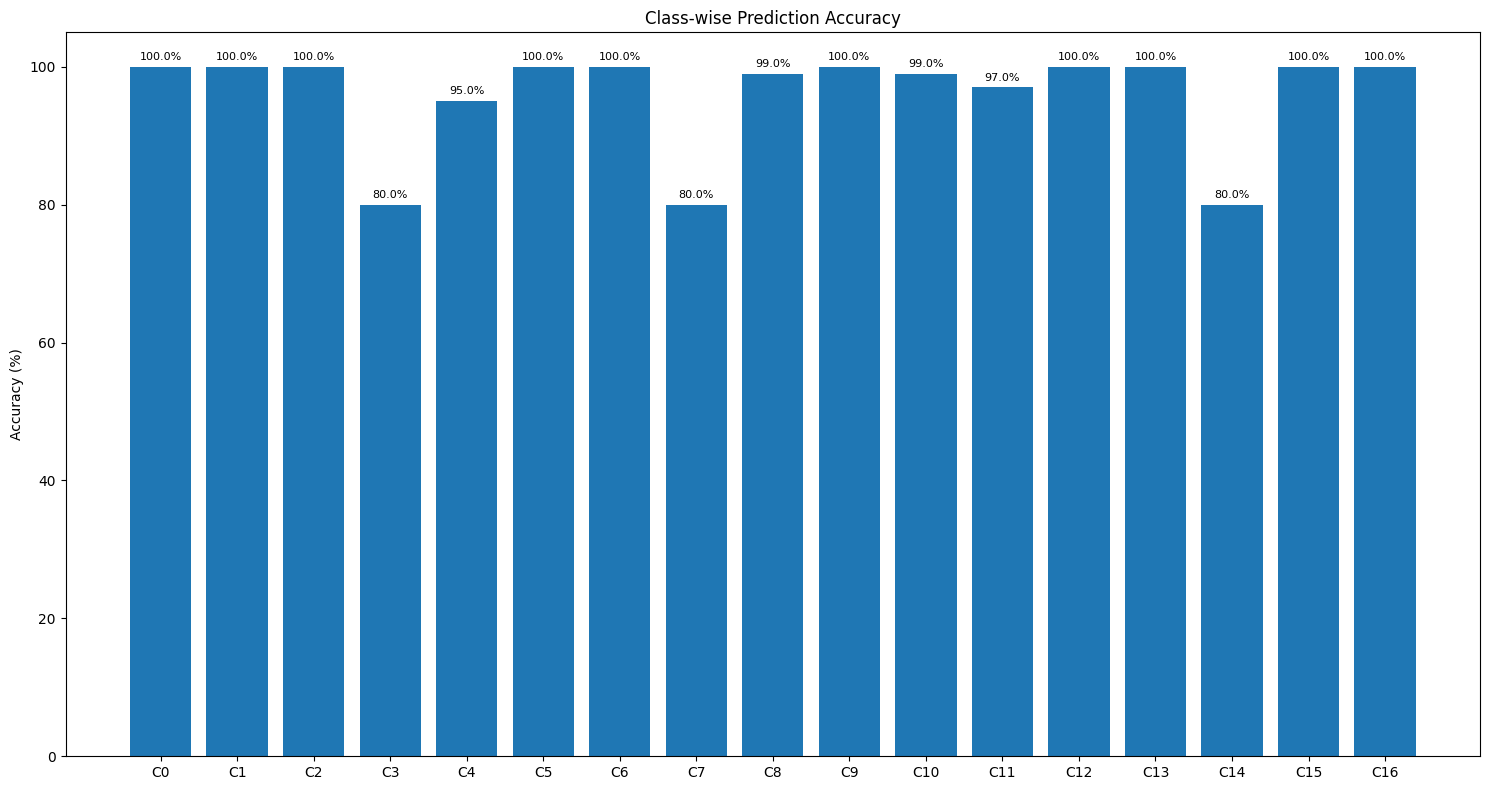

Worst 3 classes:
Class 3: 80.0%
Class 7: 80.0%
Class 14: 80.0%


In [13]:
# 클래스별 성능 시각화
meta_df = pd.read_csv("../data/meta.csv")
avg_acc = {c: np.mean([f.get(c,0) for f in fold_class_accuracies]) for c in range(17)}

plt.figure(figsize=(15, 8))
classes = list(avg_acc.keys())
accs = [avg_acc[c] * 100 for c in classes]
names = [f"C{c}" for c in classes]

plt.bar(range(17), accs)
plt.xticks(range(17), names)
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Prediction Accuracy')
for i, acc in enumerate(accs):
    plt.text(i, acc + 1, f'{acc:.1f}%', ha='center', fontsize=8)
plt.tight_layout()
plt.show()

print("Worst 3 classes:")
worst = sorted(avg_acc.items(), key=lambda x: x[1])[:3]
for c, acc in worst:
    print(f"Class {c}: {acc*100:.1f}%")

In [14]:
# 5-Fold 앙상블 모델 준비
ensemble_models = []
for i, state_dict in enumerate(fold_models):
    fold_model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
    fold_model.load_state_dict(state_dict)
    fold_model.eval()
    ensemble_models.append(fold_model)
print(f"Using ensemble of all {len(ensemble_models)} fold models for inference")

Using ensemble of all 5 fold models for inference


## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [15]:
# # load model
# model = timm.create_model(
#     model_name,
#     pretrained=True,
#     num_classes=17
# ).to(device)
# loss_fn = nn.CrossEntropyLoss()
# optimizer = Adam(model.parameters(), lr=LR)

In [16]:
# for epoch in range(EPOCHS):
#     ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)
#     ret['epoch'] = epoch

#     log = ""
#     for k, v in ret.items():
#       log += f"{k}: {v:.4f}\n"
#     print(log)

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [17]:
# preds_list = []

# model.eval()
# for image, _ in tqdm(tst_loader):
#     image = image.to(device)

#     with torch.no_grad():
#         preds = model(image)
#     preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

In [18]:
# pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
# pred_df['target'] = preds_list

In [19]:
# sample_submission_df = pd.read_csv("../data/sample_submission.csv")
# assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [20]:
# pred_df.to_csv("pred.csv", index=False)

In [21]:
# Temperature Scaling 클래스 정의
class TemperatureScaling(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
    
    def forward(self, logits):
        return logits / self.temperature

In [22]:
essential_tta_transforms = [
    # 원본
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 90도 회전들
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[90, 90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[180, 180], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[-90, -90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 밝기 개선
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.RandomBrightnessContrast(brightness_limit=[0.3, 0.3], contrast_limit=[0.3, 0.3], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
]

In [23]:
# TTA 추론을 위한 Dataset 클래스
class TTAImageDataset(Dataset):
    def __init__(self, data, path, transforms):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.transforms = transforms  # 여러 transform을 리스트로 받음

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        
        # 모든 transform을 적용한 결과를 리스트로 반환
        augmented_images = []
        for transform in self.transforms:
            aug_img = transform(image=img)['image']
            augmented_images.append(aug_img)
        
        return augmented_images, target

In [24]:
# TTA Dataset 생성
tta_dataset = TTAImageDataset(
    "../data/sample_submission.csv",
    "../data/test/",
    essential_tta_transforms
)

# TTA DataLoader (배치 크기를 줄여서 메모리 절약)
tta_loader = DataLoader(
    tta_dataset,
    batch_size=64,  # TTA는 메모리를 많이 사용하므로 배치 크기 줄임
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"TTA Dataset size: {len(tta_dataset)}")

TTA Dataset size: 3140


In [25]:
def ensemble_tta_inference(models, loader, transforms, confidence_threshold=0.9):
    """5-Fold 모델 앙상블 + TTA 추론"""
    all_predictions = []
    
    for batch_idx, (images_list, _) in enumerate(tqdm(loader, desc="Ensemble TTA")):
        batch_size = images_list[0].size(0)
        ensemble_probs = torch.zeros(batch_size, 17).to(device)
        
        # 각 fold 모델별 예측
        for model in models:
            with torch.no_grad():
                # 각 TTA 변형별 예측
                for images in images_list:
                    images = images.to(device)
                    preds = model(images)
                    probs = torch.softmax(preds, dim=1)
                    ensemble_probs += probs / (len(models) * len(images_list))
        
        final_preds = torch.argmax(ensemble_probs, dim=1)
        all_predictions.extend(final_preds.cpu().numpy())
    
    return all_predictions

In [26]:
# 앙상블 TTA 실행
print("Starting Ensemble TTA inference...")
tta_predictions = ensemble_tta_inference(
    models=ensemble_models, 
    loader=tta_loader, 
    transforms=essential_tta_transforms,
    confidence_threshold=0.9
)

Starting Ensemble TTA inference...


Ensemble TTA:   0%|          | 0/50 [00:00<?, ?it/s]

Ensemble TTA: 100%|██████████| 50/50 [09:17<00:00, 11.15s/it]


In [27]:
# TTA 결과로 submission 파일 생성
tta_pred_df = pd.DataFrame(tta_dataset.df, columns=['ID', 'target'])
tta_pred_df['target'] = tta_predictions

In [28]:
# 기존 submission과 동일한 순서인지 확인
sample_submission_df = pd.read_csv("../data/sample_submission.csv")
assert (sample_submission_df['ID'] == tta_pred_df['ID']).all()

In [29]:
# TTA 결과 저장
tta_pred_df.to_csv("../submission/choice.csv", index=False)
print("TTA predictions saved")

print("TTA Prediction sample:")

TTA predictions saved
TTA Prediction sample:


In [30]:
tta_pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,12
4,00901f504008d884.jpg,2
